<a href="https://colab.research.google.com/github/neharana404/neharana404/blob/main/Lab1_ECE442.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 442 Network Science Analytics - Laboratory 1
## Manipulating network graphs, introduction to NetworkX and PyTorch Geometric

In this first laboratory we will work with a real dataset, generate a network graph and analyze it using the Python package **[NetworkX](https://networkx.org/)**. We will also introduce **[pandas](https://pandas.pydata.org/)**, an excellent library to load and process datasets efficiently. A third goal of this assigment is to start familiarizing ourselves with **[PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)**, a library built upon PyTorch to easily write and train Graph Neural Networks (GNNs) for a wide range of applications related to network data.

To this end, we will study the email graph of the Enron corporation. Emails exchanged among several Enron employees in the period between November 1998 and June 2002 were made publicly available during the federal investigation; for additional details about the Enron scandal see https://en.wikipedia.org/wiki/Enron_scandal.  The completed dataset can be accessed from http://www.cs.cmu.edu/~enron/. Here we will use a smaller and curated version of the email corpus (for instance, with the email body removed), which can be obtained from http://cis.jhu.edu/~parky/Enron/enron.html.

For those of you who have never worked with the aforementioned libraries, we hope this laboratory will provide a useful first exposure and bring you up to speed with what you will need for the rest of the course. We ask you upload to Gradescope the answers to all the questions that follow in a report submitted as a single pdf file. You are welcome to explore and play with the data beyond what we ask; let us know what you find!

### Network graph generation

In [ ]:
# load the libraries we will use
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# get the dataset (see http://cis.jhu.edu/~parky/Enron/enron.html for additional details)
!wget http://cis.jhu.edu/~parky/Enron/employees
!wget http://cis.jhu.edu/~parky/Enron/execs.email.linesnum

In [ ]:
# load the data
df_mails = pd.read_csv('execs.email.linesnum', names=['time','from','to'], sep=' ')
df_employees = pd.read_csv('employees', sep='\t', names=['mail', 'name and more'])


In the variable `df_mails` we store a pandas [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) with the id of the sender (`from` column) and recepient (`to`) of an email sent at a given timestamp (`time`). In addition, the email user account and other information from the employees are stored in the dataframe  `df_employees`. You can think of a dataframe as an indexed table, but pandas offers plenty of additional functionalities, some of which we will leverage to process the data and generate the network graph.

In [ ]:
# compute the dates from the timestamp (in seconds from 1/1/1970)
df_mails['date'] = pd.to_datetime(df_mails.time, unit='s')

# strangely enough there are dates from 1979. Let's remove those.
df_mails = df_mails[df_mails.date.dt.year>1980]

df_mails.head()

### Graph construction for the entire time horizon

First we construct a network graph spanning all emails.


In [ ]:
# count number of emails between a pair of users
mails_exchanged = df_mails.groupby(['from', 'to']).count().reset_index()
mails_exchanged.head()


In [ ]:
# the columns "time" and "date" have the same information, so abrbitrarily change one to "weight" which I will use to define edge weights
mails_exchanged.rename(columns={'time':'weight'}, inplace=True)
mails_exchanged.head()

In [ ]:
# and here is something nice: pandas can be interfaced with networkx.
G = nx.from_pandas_edgelist(mails_exchanged, source='from', target='to', edge_attr='weight', create_using=nx.DiGraph)
G_new = G
# remove self loops
G.remove_edges_from(nx.selfloop_edges(G))

# generating a graph visualization is easy...
nx.draw_networkx(G)
plt.show()

In [ ]:
# ... but cannot see much, typical ball of yarn phenomena we encounter with large graphs.

# so let's be a little bit more creative
positions = nx.circular_layout(G)
edges = G.edges()
weights = np.array([G[u][v]['weight'] for u,v in edges])

between_dict = nx.betweenness_centrality(G)
between = np.array(list(between_dict.values()))

plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G, pos=positions, node_color=10*np.log(1+between/(np.min(between)+1e-9)), cmap='Blues')
nx.draw_networkx_edges(G, alpha=0.1, width=np.log10(weights+1), pos=positions)
nx.draw_networkx_labels(G, pos=positions, font_color='black')
plt.title('Network graph of emails exchanged during the whole time period.\n Edge width is proportional to the number of emails exchanged (log scale).\n \
  Vertex color intensity is proportional to its betweeness centrality (log scale).', fontsize=18)
plt.show()

### Interfacing NetworkX with NumPy

In [ ]:
# in addition to interfacing with pandas, NetworkX can work with NumPy and matrices

# for instance, obtaining the adjacency matrix is as simple as this
G_np = nx.to_numpy_array(G,nodelist=range(G.number_of_nodes()))
# we plot it using seaborn
sns.heatmap(np.log10(G_np+1), cmap='Greys')
plt.show()
# or we can exclusively focus on the connecitivity pattern...
sns.heatmap(G_np>0, cmap='Greys')
plt.show()


## Network analysis

Now you should use the Networkx or NumPy APIs to compute various summary statistics of the network graph `G(V,E)`:


1.   Number of directed edges (arcs) in the network, i.e., the number of unique ordered pairs $(u,v)\in E$,
where $u,v\in V$.
2.   Number of undirected edges in the network, i.e., the number of unique unordered pairs $(u,v)\in E$,
where $u,v\in V$. (This means that if at least one of $(u,v)\in E$ or $(v,u)\in E$, you count the pair as a single undirected edge.)
3.   Number of mutual arcs in the network, i.e., the number of pairs $(u,v)$, where $\{(u,v),(v,u)\}\subseteq E$
and $u,v\in V$. (This means that if both $(u,v)\in E$ and $(v,u)\in E$, you count the pair as a mutual arc.)
4.   Number of nodes with $d_v^{\text{in}}=0$, and list the corresponding employee names.
5.   Number of nodes with $d_v^{\text{out}}=0$, and list the corresponding employee names.
6.   Number of employees that have been contacted by 30 or more employees. Generate a new graph visualization and: (i) color these nodes in red; (ii) label these nodes with the corresponding employee names.  
7.   Number of employees that have contacted 30 or more employees. Generate a new graph visualization and: (i) color these nodes in red; (ii) label these nodes with the corresponding employee names.
8.   Histogram of vertex degrees (separate $d_v^{\text{in}}$ and $d_v^{\text{out}}$). You can for instance use the histplot tool in seaborn.



**1. Number of directed edges (arcs) in the network, i.e., the number of unique ordered pairs  (𝑢,𝑣)∈𝐸 , where  𝑢,𝑣∈𝑉 .**

In [ ]:
u_directed_edges = G.number_of_edges()
u_directed_edges

**2. Number of undirected edges in the network, i.e., the number of unique unordered pairs  (𝑢,𝑣)∈𝐸 , where  𝑢,𝑣∈𝑉 . (This means that if at least one of  (𝑢,𝑣)∈𝐸  or  (𝑣,𝑢)∈𝐸 , you count the pair as a single undirected edge.)**

In [ ]:
u_undirected = G.to_undirected().number_of_edges()
u_undirected

**3. Number of mutual arcs in the network, i.e., the number of pairs  (𝑢,𝑣) , where  {(𝑢,𝑣),(𝑣,𝑢)}⊆𝐸  and  𝑢,𝑣∈𝑉 . (This means that if both  (𝑢,𝑣)∈𝐸  and  (𝑣,𝑢)∈𝐸 , you count the pair as a mutual arc.)**

In [ ]:
mutual_arcs =u_directed_edges - u_undirected
mutual_arcs

**4. Number of nodes with  𝑑in𝑣=0 , and list the corresponding employee names.**

In [ ]:
in_degrees = [node for node in G.nodes() if G.in_degree(node) == 0]
in_degree_names = [''.join(df_employees.iloc[i,1].split()[:2]) for i in in_degrees]

print(f'{len(in_degrees)} employees \n')
print(f'List of employees:')
employee_names = '\n'.join([f"{str(element)} ({index})" for index, element in zip(in_degrees,in_degree_names)])
print(employee_names)

**5. Number of nodes with  𝑑out𝑣=0 , and list the corresponding employee names**

In [ ]:
out_degrees = [node for node in G.nodes() if G.out_degree(node) == 0]
out_degrees_names = [''.join(df_employees.iloc[i,1].split()[:2]) for i in out_degrees]

print(f'{len(out_degrees)} employees \n')
print(f'List of employees:')
employee_names = '\n'.join([f"{str(element)} ({index})" for index, element in zip(out_degrees,out_degrees_names)])
print(employee_names)

**6. Number of employees that have been contacted by 30 or more employees. Generate a new graph visualization and: (i) color these nodes in red; (ii) label these nodes with the corresponding employee names**

In [ ]:
contacted_by_30_or_more = [node for node in G.nodes() if G.in_degree(node) > 29]
contacted_name_by_30_or_more = [''.join(df_employees.iloc[i,1].split()[:2]) for i in contacted_by_30_or_more]

print(f'{len(contacted_name_by_30_or_more)} employees \n')
print(f'List of employees:')
employee_names = '\n'.join([f"{str(element)} ({index})" for index, element in zip(contacted_by_30_or_more, contacted_name_by_30_or_more)])
print(employee_names)

In [ ]:
node_colors = ['red' if node in contacted_by_30_or_more else 'lightblue' for node in G.nodes()]

betweenness_centrality_filtered = {node: nx.betweenness_centrality(G)[node] for node in contacted_by_30_or_more}
between_filtered = np.array(list(betweenness_centrality_filtered.values()))


node_color_intensity = 10 * np.log(1 + between / (np.min(between) + 1e-9))
node_color_intensity_filered = 10 * np.log(1 + between_filtered / (np.min(between_filtered) + 1e-9))

plt.figure(figsize=(15,15))
nodes = nx.draw_networkx_nodes(G, pos=positions, node_color=node_color_intensity, cmap='Blues')
nx.draw_networkx_edges(G, pos=positions, alpha=0.1, width=np.log10(weights+1))
nx.draw_networkx_labels(G, pos=positions, font_color='black')

red_nodes = [node for node in G.nodes() if node in contacted_by_30_or_more]
if red_nodes:
    nx.draw_networkx_nodes(G, pos=positions, nodelist=red_nodes, node_color=node_color_intensity_filered, linewidths=1, cmap='Reds')

plt.title('Network graph of emails exchanged during the whole time period', fontsize=18)
plt.show()

**7. Number of employees that have contacted 30 or more employees. Generate a new graph visualization and: (i) color these nodes in red; (ii) label these nodes with the corresponding employee names.**

In [ ]:
contacted_30_or_more = [node for node in G.nodes() if G.out_degree(node) > 29]
contacted_name_30_or_more = [''.join(df_employees.iloc[i,1].split()[:2]) for i in contacted_30_or_more]

print(f'{len(contacted_name_30_or_more)} employees \n')
print(f'List of employees:')
employee_names = '\n'.join([f"{str(element)} ({index})" for index, element in zip(contacted_30_or_more, contacted_name_30_or_more)])
print(employee_names)

In [ ]:
node_colors = ['red' if node in contacted_30_or_more else 'lightblue' for node in G.nodes()]

betweenness_centrality_filtered = {node: nx.betweenness_centrality(G)[node] for node in contacted_30_or_more}
between_filtered = np.array(list(betweenness_centrality_filtered.values()))


node_color_intensity = 10 * np.log(1 + between / (np.min(between) + 1e-9))
node_color_intensity_filered = 10 * np.log(1 + between_filtered / (np.min(between_filtered) + 1e-9))

plt.figure(figsize=(15,15))
nodes = nx.draw_networkx_nodes(G, pos=positions, node_color=node_color_intensity, cmap='Blues')
nx.draw_networkx_edges(G, pos=positions, alpha=0.1, width=np.log10(weights+1))
nx.draw_networkx_labels(G, pos=positions, font_color='black')

red_nodes = [node for node in G.nodes() if node in contacted_30_or_more]
if red_nodes:
    nx.draw_networkx_nodes(G, pos=positions, nodelist=red_nodes, node_color=node_color_intensity_filered, linewidths=1, cmap='Reds')

plt.title('Network graph of emails exchanged during the whole time period', fontsize=18)
plt.show()

**8.Histogram of vertex degrees (separate  𝑑in𝑣  and  𝑑out𝑣 ). You can for instance use the histplot tool in seaborn.**

In [ ]:
in_degrees = dict(G.in_degree()).values()
out_degrees = dict(G.out_degree()).values()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(list(in_degrees), bins=max(in_degrees)+1, kde=False, color='blue')
plt.title('In-Degree Histogram')
plt.xlabel('In-Degree')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(list(out_degrees), bins=max(out_degrees)+1, kde=False, color='red')
plt.title('Out-Degree Histogram')
plt.xlabel('Out-Degree')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Dynamic (temporal) network analysis

So far we have examined the entire dataset and ignored its temporal dimension. To bridge this gap, in this section we will carry out a simple dynamic network analysis to study how the graph changes across time.

In [ ]:
# let's cluster emails per week, so we first check to which week a given email corresponds to and then we add it to df_mails
df_mails['week'] = df_mails.date.dt.to_period('W')
print(df_mails.head())

# per week aggregation. This generates a GroupBy object over which we can iterate, and contains all data for each week
grouped_week = df_mails.groupby('week')
# list that will contain the weekly network graphs
graphs = []
# list that will contain the weeeks themselves. Come be used to identify timestamps down the road.
weeks = []

for week_id, mails_group in grouped_week:
    # we basically repeated what we did for the entire graph, but on a per week basis.
    # we will be storing the weekly graphs in a list. Arguably not the most efficient approach, but the dataset is not that large

    # count number of emails between a pair of users this week
    mails_exchanged = mails_group.groupby(['from', 'to']).count().reset_index()
    # the columns have the same information, so abrbitrarily change one to "weight" which I will use to define edge weights
    mails_exchanged.rename(columns={'week':'weight'}, inplace=True)
    G = nx.from_pandas_edgelist(mails_exchanged, source='from', target='to', edge_attr='weight', create_using=nx.DiGraph)

    # remove self loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # add the new graph to the list
    graphs.append(G)
    weeks.append(week_id)



In [ ]:
# let's examine the temporal evolution of some simple summary statistcs

num_nodes = [current_graph.number_of_nodes() for current_graph in graphs]
num_arcs = [current_graph.number_of_edges() for current_graph in graphs]
pd.DataFrame({'n_nodes':num_nodes, 'n_arcs':num_arcs}, index=weeks).plot(figsize=(12,6))
plt.grid()
plt.legend(['Number of nodes', 'Number of arcs'])
plt.show()


### Changes in the network graph
9. Pick two node centrality measures of your choice (see e.g., Ch. 4 of E. Kolaczyk's book Statistical Analysis of Network Data, the [lecture slides on centrality](https://www.hajim.rochester.edu/ece/sites/gmateos/ECE442/Slides/block_3_descriptive_analysis_properties_part_c.pdf), or the [NetworkX documentation](https://networkx.org/documentation/stable/reference/algorithms/centrality.html)) and indicate who was the most central Enron employee each week according to each of these measures.  Compare your results with what you obtain for the "entire" graph (namely, the network constructed earlier using data for the whole time horizon).
10. Experiment with a few graph-level summary statistics (e.g., number of nodes, edges, average degree, average clustering coefficient, or any other of your liking) and use them to identify some of the major events tied to the scandal (Figure 8 in https://arxiv.org/abs/1403.0989 has a very nice timeline that could help). Likely you should be able to spot the launch of Enron online and Stephen Cooper's ascent to the CEO role.

**9. Pick two node centrality measures of your choice (see e.g., Ch. 4 of E. Kolaczyk's book Statistical Analysis of Network Data, the lecture slides on centrality, or the NetworkX documentation) and indicate who was the most central Enron employee each week according to each of these measures. Compare your results with what you obtain for the "entire" graph (namely, the network constructed earlier using data for the whole time horizon).**

**Betweenness Centrality**

In [ ]:
betweenness_centrality = nx.betweenness_centrality(G_new)
most_central_employee = max(betweenness_centrality, key=betweenness_centrality.get)
most_central_employee = ' '.join(df_employees.iloc[most_central_employee,1].split()[:2])
print(f'Central employee over all time is {most_central_employee}')

In [ ]:
betweenness_centrality = nx.betweenness_centrality(G)

central_employee_per_week = []

for i, G in enumerate(graphs):
    between_vals_weekly = nx.betweenness_centrality(G)
    central_employee_weekly = max(between_vals_weekly, key=lambda k: between_vals_weekly[k])
    central_employee_per_week.append(df_employees.loc[central_employee_weekly, 'name and more'])

print('Central employee per week are:\n')
for i in range(len(central_employee_per_week)):
    print(weeks[i], ":", central_employee_per_week[i])

**Closeness Centrality**

In [ ]:
closeness_centrality = nx.closeness_centrality(G_new)
most_central_employee = max(closeness_centrality, key=closeness_centrality.get)
most_central_employee = ' '.join(df_employees.iloc[most_central_employee,1].split()[:2])
print(f'Central employee over all time is {most_central_employee}')

In [ ]:
closeness_centrality = nx.closeness_centrality(G)

central_employee_per_week = []

for i, G in enumerate(graphs):
    between_vals_weekly = nx.closeness_centrality(G)
    central_employee_weekly = max(between_vals_weekly, key=lambda k: between_vals_weekly[k])
    central_employee_per_week.append(df_employees.loc[central_employee_weekly, 'name and more'])

print('Central employee per week are:\n')
for i in range(len(central_employee_per_week)):
    print(weeks[i], ":", central_employee_per_week[i])

**10. Experiment with a few graph-level summary statistics (e.g., number of nodes, edges, average degree, average clustering coefficient, or any other of your liking) and use them to identify some of the major events tied to the scandal (Figure 8 in https://arxiv.org/abs/1403.0989 has a very nice timeline that could help). Likely you should be able to spot the launch of Enron online and Stephen Cooper's ascent to the CEO role.**

In [ ]:
metrics_df = pd.DataFrame({
    'n_nodes': [g.number_of_nodes() for g in graphs],
    'n_arcs': [g.number_of_edges() for g in graphs],
    'density': [nx.density(g) for g in graphs]
}, index=weeks)

fig, axs = plt.subplots(3, 1, figsize=(12, 18))

metrics_df['n_nodes'].plot(ax=axs[0], grid=True, legend=True)
axs[0].set_title('Weekly Number of Nodes in the Network')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Number of Nodes')

metrics_df['n_arcs'].plot(ax=axs[1], grid=True, legend=True)
axs[1].set_title('Weekly Number of Edges in the Network')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Number of Edges')

metrics_df['density'].plot(ax=axs[2], grid=True, legend=True)
axs[2].set_title('Weekly Density of the Network')
axs[2].set_xlabel('Week')
axs[2].set_ylabel('Density')

plt.tight_layout()
plt.show()



```
# This is formatted as code
```

## Introduction to Pytorch Geometric (PyG)
**[PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric)** is a Python library for deep learning on graphs, which provides the required functionatility to work with Graph Neural Networks (GNNs). The library is an extension of **[PyTorch](https://pytorch.org/)**, arguably the most widely adopted open source deep learning framework.

In [ ]:
import torch
print(f"PyTorch version is {torch.__version__}")

In [ ]:
# install PyG for the working version of PyTorch
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric

PyG includes several network datasets in the package **[torch_geometric.datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets)**. In this part of the laboratory we will work with a dataset that has become a *de facto* testbed for community detection algorithms, namely [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [ ]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

The dataset consists of a single network graph, each vertex has an associated vector in $\mathbb{R}^{34}$ (a so-termed nodal *feature* vector), and nodes are partitioned in 4 classes. Let's examine some other network summary statistics:

In [ ]:
# focus on the first time (and only) graph
data = dataset[0]

print(data)
print('==============================================================')

# network charactersitics
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average degree: {(2*data.num_edges) / data.num_nodes:.2f}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has self loops: {data.has_self_loops()}')
print(f'Graph is undirected: {data.is_undirected()}')

A graph in PyG by an object of type [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data). Each of these objects has at least 5 attributes:
- **`x`**: is a network-wide feature matrix associated to the vertices (that is, a matrix whose columns are the nodal feature vectors). It is an object of type [`tensor`](https://pytorch.org/docs/stable/tensors.html), torch's native type to store matrices (the equivalent to [`ndarray`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) in numpy).
- **`edge_index`**: is the graph's connectivity matrix in [COO](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)) format. This format is very useful to store and work with *sparse* matrices (those having a large number of zeros, here denoting non-edges). It only stores a list of nodes connected by edges, instead of storting the whole adjacency matrix.
- **`y`**: is a matrix of nodal labels (for the Karate club, the matrix that encodes the class membership of each vetex).
- **`train_mask`**: binary matrix indicating the subset of vertices that are part of the training set. This will be useful down the road when we e.g.,  build and train a GNN model for node classification.
- **`edge_attr`**: is a network-wide feature matrix associated to the edges. Since the Karate club network is unweighted, the dataset has no edge features.

In [ ]:
print('data.x')
print('========================================')
print(data.x)
print('\ndata.edge_index')
print('=========================================')
print(data.edge_index.t())
print('\ndata.y')
print('=========================================')
print(data.y)
print('\ndata.train_mask')
print('=========================================')
print(data.train_mask)
print('\ndata.edge_attr')
print('=========================================')
print(data.edge_attr)

PyG offers a simple interface to convert a graph into NetworkX's format

In [ ]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)
nx.draw_networkx(G,node_color=data.y,pos=nx.spring_layout(G, seed=42))

## Verify properties of the graph Laplacian
The goal of the following questions is to empirically verify a few properties of the graph Laplacian matrix. In the **optional** exercise below, you are asked to mathematically establish those properties.

11. Compute the graph Laplacian matrix $\mathbf{L}$ for Zachary's karate club network. You are encouraged to use some suitable function from the subpackage [`torch_geometric.utils`](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html).
12. Check that $\mathbf{L}$ has a 0 eigenvalue and verify that the vector of all ones $[1,1,\dots,1]^\top$ is the corresponding eigenvector. The subpackage [`torch.linalg`](https://pytorch.org/docs/stable/linalg.html) may be useful to that end.
13. Corroborate that $\mathbf{L}$ is a symmetric positive semidefinite matrix.
14. Form a matrix $\tilde{\mathbf{B}}$ as described in Part 2 of the optional exercise below and verify that $\mathbf{L}=\tilde{\mathbf{B}}\tilde{\mathbf{B}}^\top$. You are encouraged to use the function [`networkx.incidence_matrix`](https://networkx.org/documentation/stable/reference/generated/networkx.linalg.graphmatrix.incidence_matrix.html).

**11. Compute the graph Laplacian matrix  𝐋  for Zachary's karate club network. You are encouraged to use some suitable function from the subpackage torch_geometric.utils.**

In [ ]:
from torch_geometric.utils import degree
from torch_geometric.utils import to_dense_adj


In [ ]:
edge_index = data.edge_index
num_nodes = data.num_nodes

adjacency_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)

for i, j in zip(edge_index[0], edge_index[1]):
    adjacency_matrix[i, j] = 1

degree_matrix = torch.diag(adjacency_matrix.sum(dim=1))

laplacian_matrix = degree_matrix - adjacency_matrix

print(laplacian_matrix)

**12. Check that  𝐋  has a 0 eigenvalue and verify that the vector of all ones  [1,1,…,1]⊤  is the corresponding eigenvector. The subpackage torch.linalg may be useful to that end.**

In [ ]:
eigenvalues, eigenvectors = torch.linalg.eigh(laplacian_matrix)

print("Eigenvalue:", eigenvalues)
print("Eigenvector:",eigenvectors)

# Check that 𝐋 has a 0 eigenvalue
zero_eigenvalue_exists = torch.isclose(eigenvalues, torch.tensor([0.]), atol=1e-6).any().item()

# Verify that the vector of all ones [1,1,…,1]⊤ is the corresponding eigenvector
ones_vector = torch.ones((laplacian_matrix.size(0), 1))
is_eigenvector = torch.isclose(laplacian_matrix @ ones_vector, torch.zeros_like(ones_vector), atol=1e-6).all().item()

print(f'\n Check that 𝐋 has a 0 eigenvalue : {zero_eigenvalue_exists} but there are value close to 0 \n Verify that the vector of all ones [1,1,…,1]⊤ is the corresponding eigenvector : {is_eigenvector}')


**13. Corroborate that  𝐋  is a symmetric positive semidefinite matrix.**

In [ ]:
is_symmetric = torch.allclose(laplacian_matrix, laplacian_matrix.T)
print("Symmetric Matrix: ", is_symmetric)

is_positive_semidefinite = torch.all(eigenvalues.real >= 0)
print("Positive Semidefinite Matrix :", is_positive_semidefinite)

**14. Form a matrix  𝐁̃   as described in Part 2 of the optional exercise below and verify that  𝐋=𝐁̃ 𝐁̃ ⊤ . You are encouraged to use the function networkx.incidence_matrix.**

In [ ]:
matrix = nx.incidence_matrix(G, oriented=True)
incidence_matrix_dense = matrix.toarray()

if np.array_equal(laplacian_matrix, (incidence_matrix_dense @ incidence_matrix_dense.T)): print("True")
else: print("False")

# Optional exercise for extra credit: prove some properties of the graph Laplacian

Consider an undirected and unweighted network graph $G(V,E)$, with order $N_v:=|V|$, size $N_e:=|E|$, and adjacency matrix $\mathbf{A}$. Let $\mathbf{D}=\text{diag}(d_1,\ldots,d_{N_v})$ be the degree matrix and $\mathbf{L}:=\mathbf{D}-\mathbf{A}$ the Laplacian of $G$.

1. Verify that $\mathbf{1}:=[1,\ldots,1]^\top$ is an eigenvector of $\mathbf{L}$ with associated eigenvalue $0$.
2. Despite $G$ being an undirected graph, consider assigning an arbitrary "virtual" orientation to each edge in $E$, i.e., for each edge pick
one of its incident vertices as the "head" and the other as the "tail". Given these assignments, consider the *signed* incidence matrix $\tilde{\mathbf{B}}\in\{-1,0,1\}^{N_v\times N_e}$ with $i,j$-th entry given by
$$\tilde{\mathbf{B}}_{ij} = \left\lbrace
\begin{array}{r l}
1,& \text{if vertex } i \text{ is incident to edge } j \text{ as a tail}\\
-1,& \text{if vertex } i \text{ is incident to } j \text{ as a head}\\
0,& \text{otherwise}
\end{array}
\right. .
$$
Prove that the Laplacian matrix can be factorized as $\mathbf{L}=\tilde{\mathbf{B}}\tilde{\mathbf{B}}^\top$.

3. Consider an arbitrary vector $\mathbf{x}=[x_1,\ldots,x_{N_v}]^\top\in \mathbb{R}^{N_v}$. Using the result in Part 2 or otherwise, show that the quadratic form
$$\mathbf{x}^\top \mathbf{L}\mathbf{x} = \sum_{(i,j) \in E} (x_i-x_j)^2.$$
Conclude that $\mathbf{L}$ is a symmetric positive semi-definite matrix.


4. Show that if $G$ is disconnected then $\mathbf{L}$ is block diagonal, with each block corresponding to the Laplacian of a particular connected component in $G$. Argue that in this case the second smallest eigenvalue of $\mathbf{L}$ necessarily vanishes, by showing that one can construct at least two linearly independent eigenvectors of $\mathbf{L}$ with associated eigenvalue $0$.

**1. Verify that  1:=[1,…,1]⊤  is an eigenvector of  𝐋  with associated eigenvalue  0 .**

To verify that $\mathbf{1} = [1, \ldots, 1]^T$ is an eigenvector of the Laplacian matrix $\mathbf{L} = \mathbf{D} - \mathbf{A}$ with an associated eigenvalue of 0 for an undirected and unweighted network graph $G(V, E)$, we use the definition of an eigenvector and eigenvalue. Specifically, for an eigenvector $\mathbf{x}$ and its corresponding eigenvalue $\lambda$, the following relationship must hold:

$$
\mathbf{Lx} = \lambda \mathbf{x}
$$

For $\mathbf{1} = [1, \ldots, 1]^T$ and $\lambda = 0$, we need to show that:

$$
\mathbf{L1} = 0 \cdot \mathbf{1} = \mathbf{0}
$$

Given the Laplacian matrix $\mathbf{L} = \mathbf{D} - \mathbf{A}$:

- $\mathbf{A}$ is the adjacency matrix of the graph, where $A_{ij} = 1$ if there is an edge between nodes $i$ and $j$, and 0 otherwise.
- $\mathbf{D}$ is the degree matrix, a diagonal matrix where each element $D_{ii}$ is the degree of node $i$, i.e., the number of edges incident to $i$.

Since $\mathbf{1}$ is a vector of ones, multiplying $\mathbf{A}$ by $\mathbf{1}$ sums the elements of each row of $\mathbf{A}$, which gives a vector where each element is the degree of the corresponding node. This is because each 1 in $\mathbf{A}$'s row contributes to the degree of the node associated with that row. Therefore, $\mathbf{A1} = [d_1, d_2, \ldots, d_{N_v}]^T$.

Multiplying $\mathbf{D}$ by $\mathbf{1}$ simply reproduces the diagonal of $\mathbf{D}$ as a vector since $\mathbf{D}$ is a diagonal matrix with the node degrees on its diagonal. Thus, $\mathbf{D1} = [d_1, d_2, \ldots, d_{N_v}]^T$.

Since $\mathbf{D1} = \mathbf{A1}$, we have:

$$
\mathbf{L1} = (\mathbf{D} - \mathbf{A})\mathbf{1} = \mathbf{D1} - \mathbf{A1} = \mathbf{0}
$$

This calculation shows that multiplying the Laplacian matrix $\mathbf{L}$ by the vector of ones $\mathbf{1}$ results in the zero vector, thus proving that $\mathbf{1}$ is indeed an eigenvector of $\mathbf{L}$ with an associated eigenvalue of 0.


2. Despite  𝐺  being an undirected graph, consider assigning an arbitrary "virtual" orientation to each edge in  𝐸 , i.e., for each edge pick one of its incident vertices as the "head" and the other as the "tail". Given these assignments, consider the signed incidence matrix  𝐁̃ ∈{−1,0,1}𝑁𝑣×𝑁𝑒  with  𝑖,𝑗 -th entry given by
𝐁̃ 𝑖𝑗=⎧⎩⎨⎪⎪1,−1,0,if vertex 𝑖 is incident to edge 𝑗 as a tailif vertex 𝑖 is incident to 𝑗 as a headotherwise.
Prove that the Laplacian matrix can be factorized as  𝐋=𝐁̃ 𝐁̃ ⊤ .

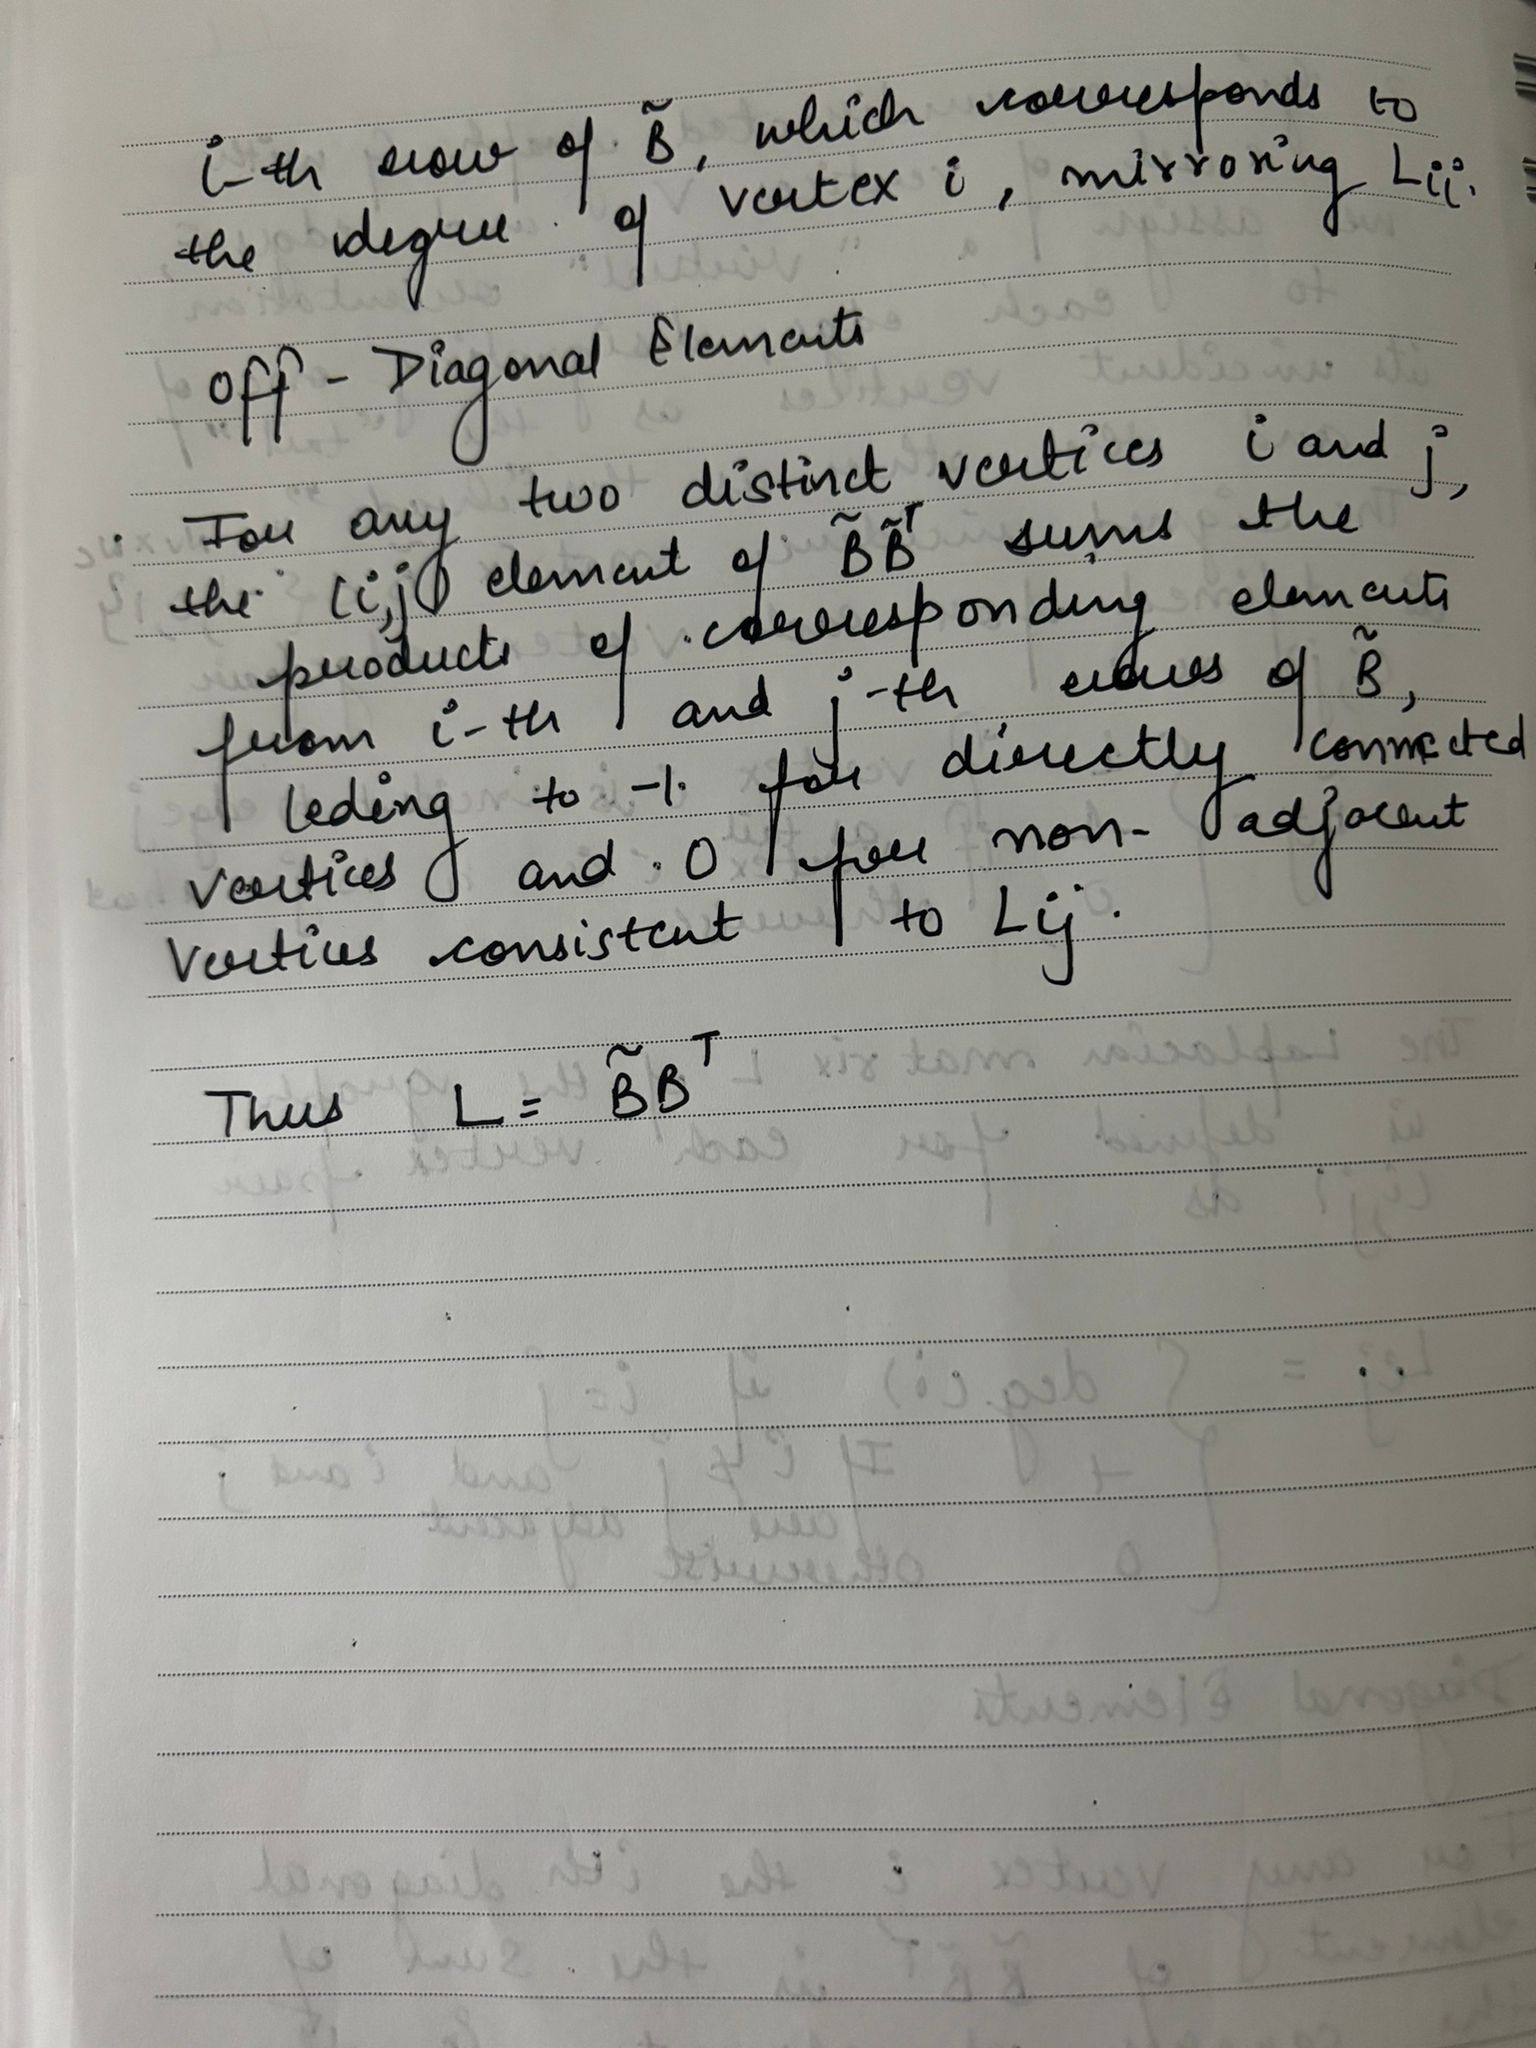

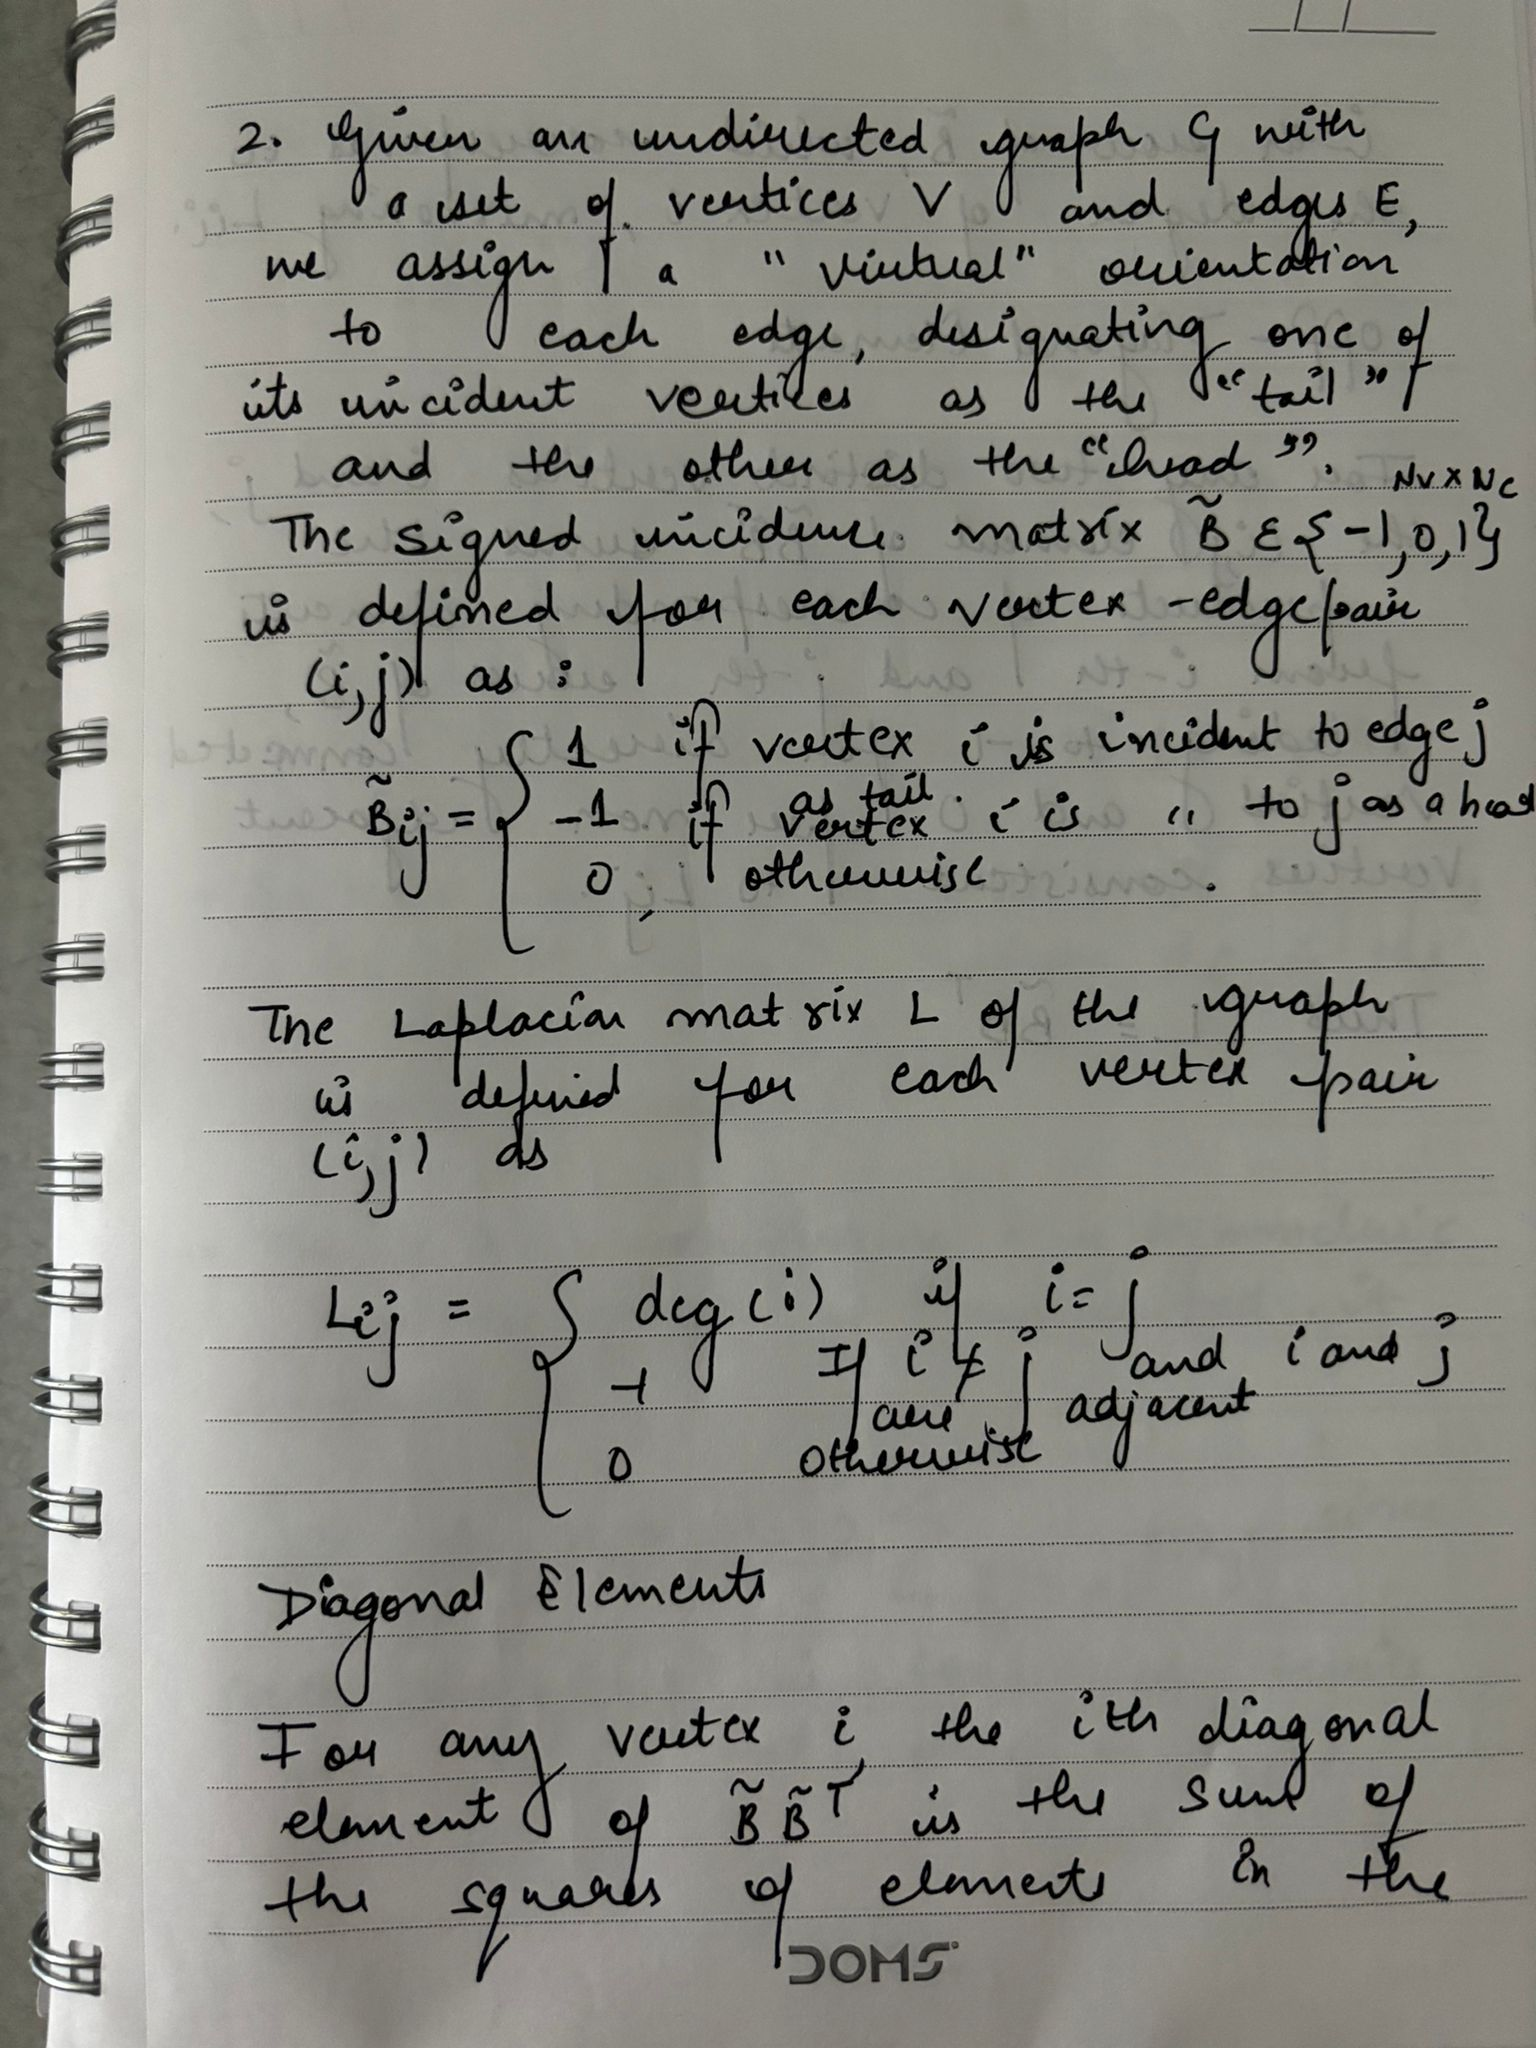

3. Consider an arbitrary vector  𝐱=[𝑥1,…,𝑥𝑁𝑣]⊤∈ℝ𝑁𝑣 . Using the result in Part 2 or otherwise, show that the quadratic form
𝐱⊤𝐋𝐱=∑(𝑖,𝑗)∈𝐸(𝑥𝑖−𝑥𝑗)2.
Conclude that  𝐋  is a symmetric positive semi-definite matrix.

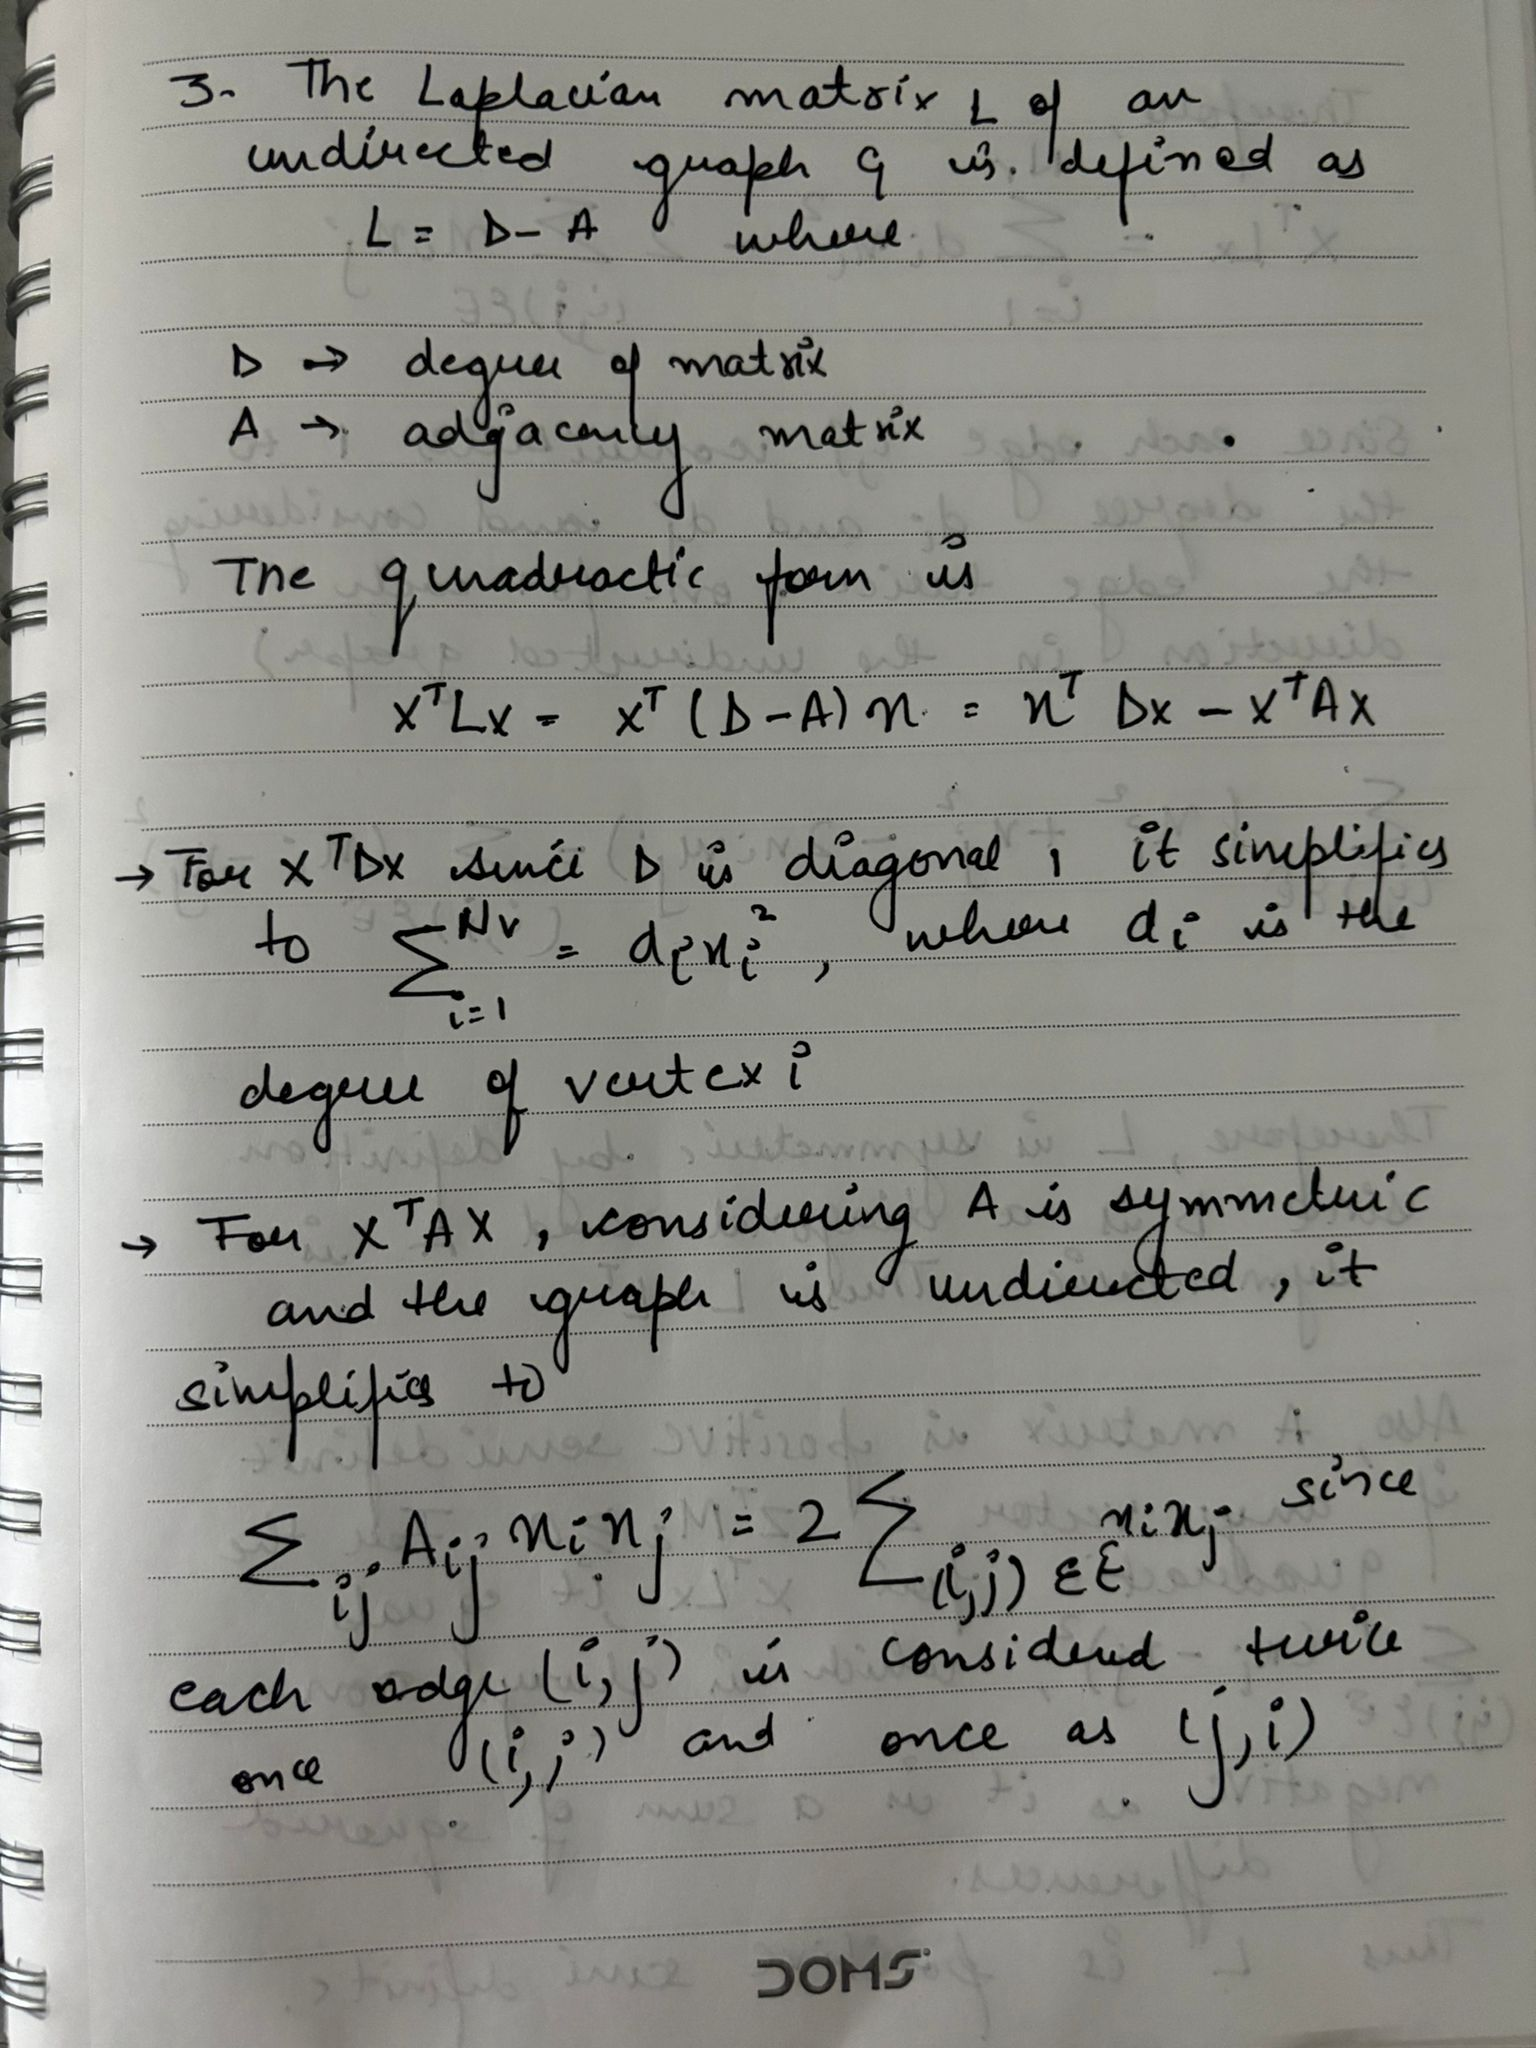

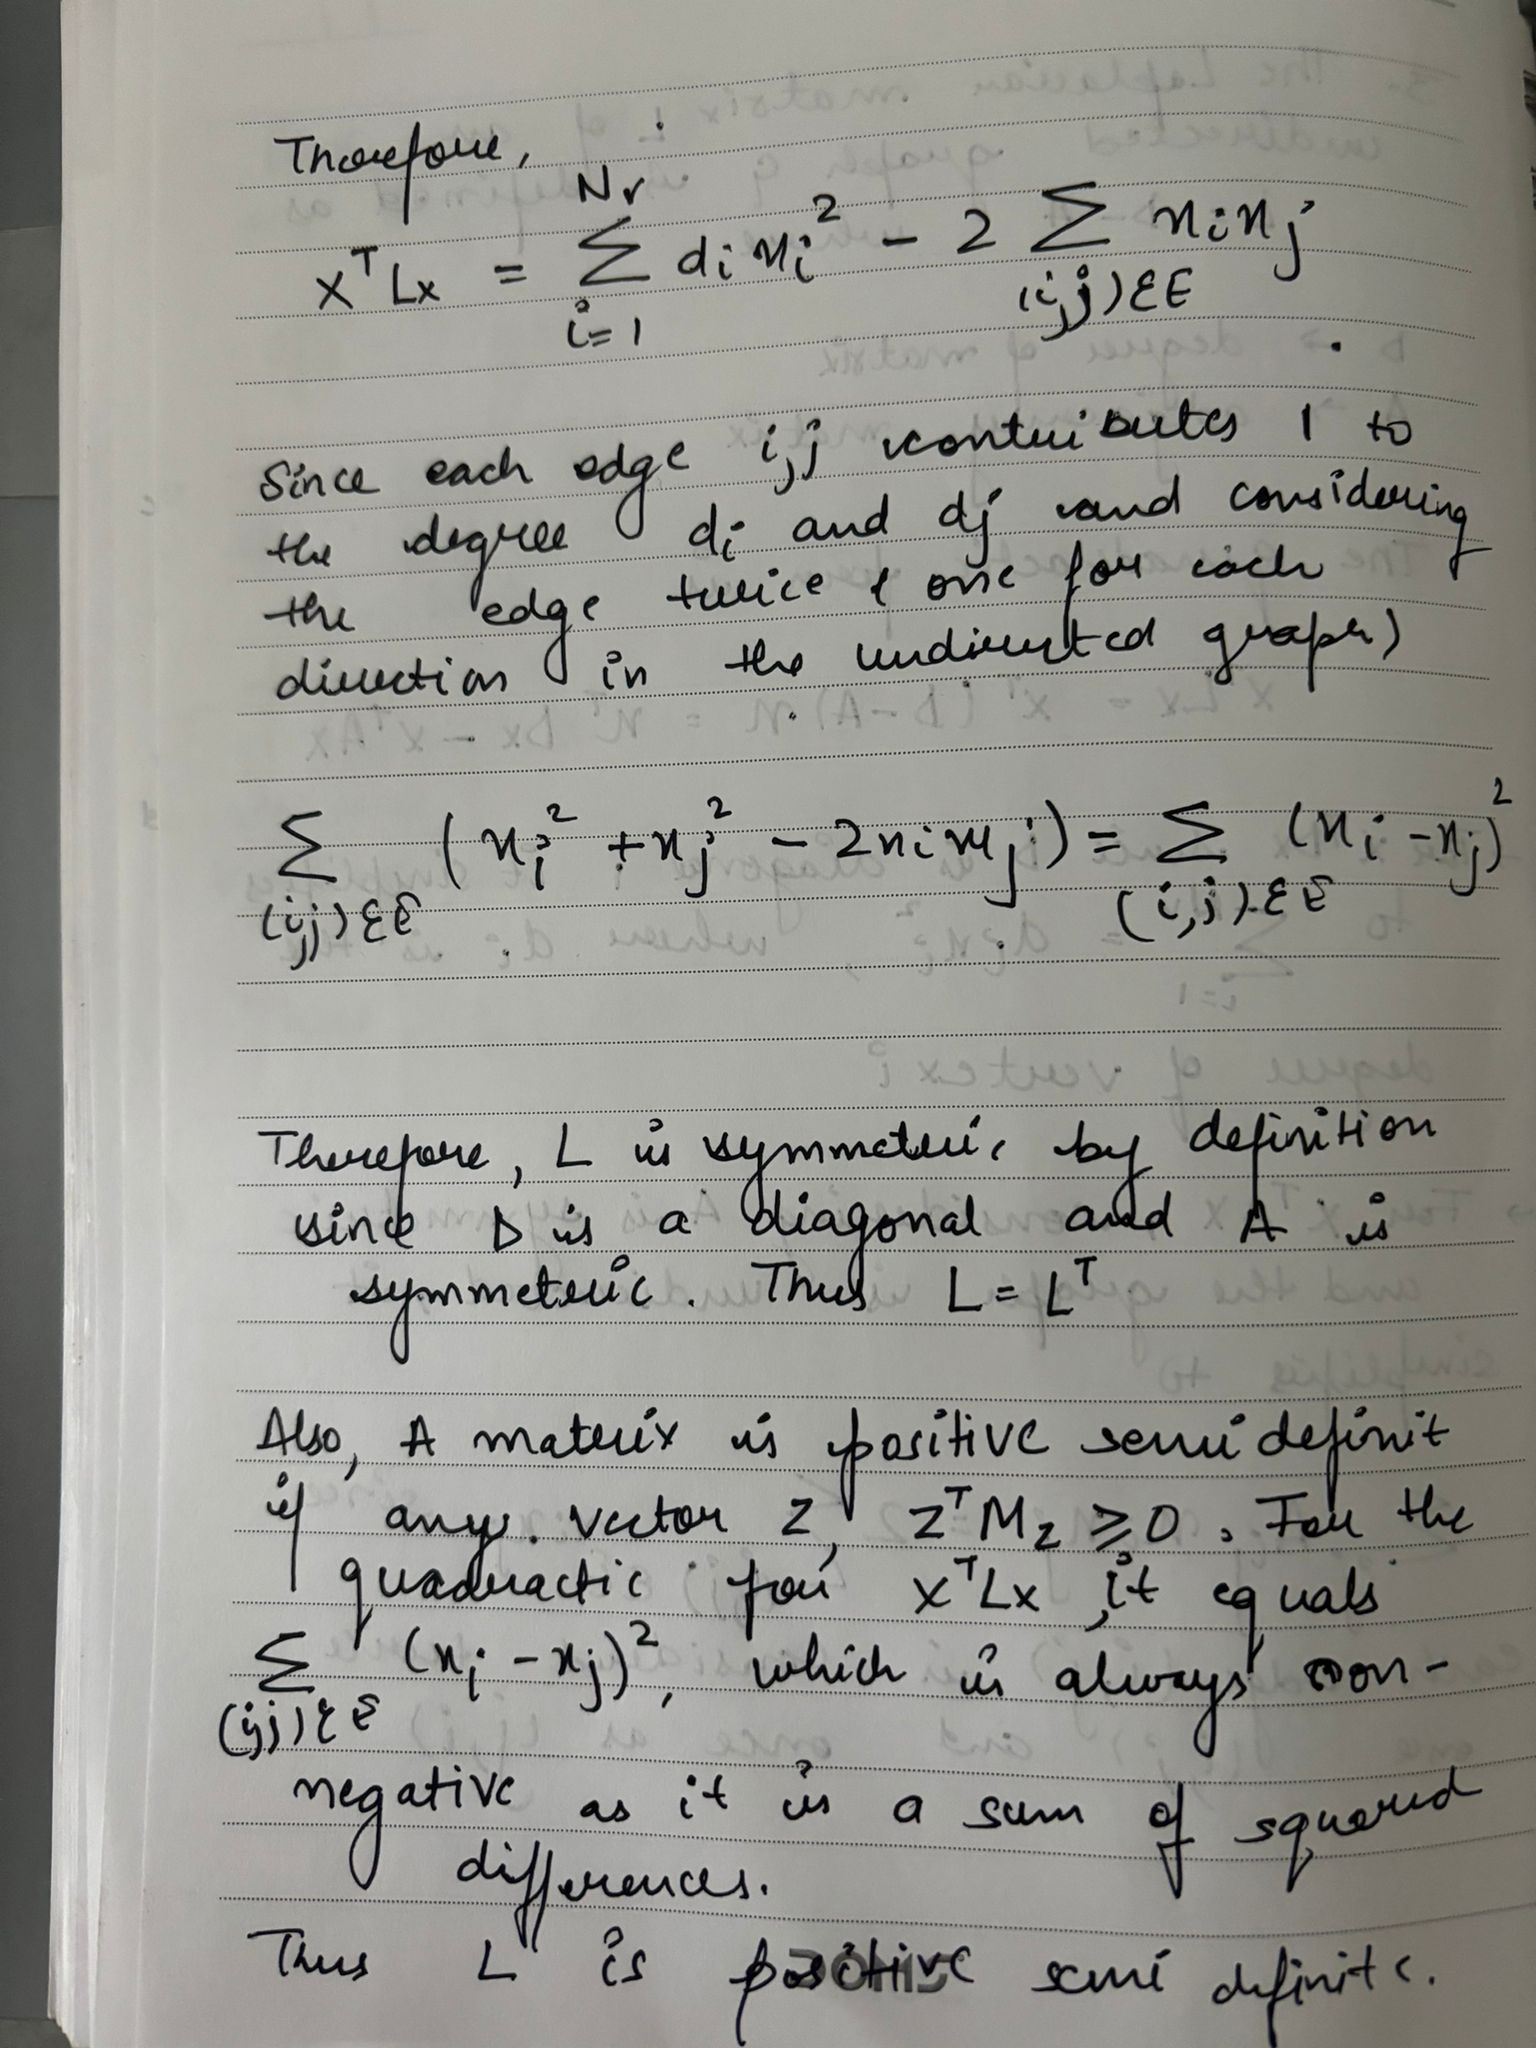

**4. Show that if  𝐺  is disconnected then  𝐋  is block diagonal, with each block corresponding to the Laplacian of a particular connected component in  𝐺 . Argue that in this case the second smallest eigenvalue of  𝐋  necessarily vanishes, by showing that one can construct at least two linearly independent eigenvectors of  𝐋  with associated eigenvalue  0 .**

#### Adjacency Matrix \(A\)

The adjacency matrix \(A\) for \(G\) is:

\
A = \begin{pmatrix}
0 & 1 & 0 & 0 \\
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
\end{pmatrix}


#### Degree Matrix \(D\)

The degree matrix \(D\), representing the degree of each vertex, is:

\
D = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{pmatrix}


#### Laplacian Matrix \(L = D - A\)

The Laplacian matrix \(L\), computed as \(L = D - A\), is:

\
L = \begin{pmatrix}
1 & -1 & 0 & 0 \\
-1 & 1 & 0 & 0 \\
0 & 0 & 1 & -1 \\
0 & 0 & -1 & 1 \\
\end{pmatrix}


Notice how \(L\) is block diagonal, with each 2 x 2 block corresponding to the Laplacian of each of the two connected components of \(G\).

#### Eigenvectors and Eigenvalues

For each \(2 X 2\) block, the eigenvalues are λ = 0 and λ = 2. The eigenvectors corresponding to λ = 0 are:

- For the first component: v1 = \begin{pmatrix}1 \\ 1 \\ 0 \\ 0\end{pmatrix}
- For the second component: v2 = \begin{pmatrix}0 \\ 0 \\ 1 \\ 1\end{pmatrix}

These eigenvectors v1 and v2 are linearly independent and correspond to the eigenvalue \(0\), illustrating the disconnected nature of \(G\).



# Acknowledgements

An intial version of this Laboratory (in Spanish) was conceived and developed by colleagues from [Facultad de Ingenieria](https://www.fing.edu.uy) in Montevideo, Uruguay and myself, for the course **[Aprendizaje Automático para Datos en Grafos](https://eva.fing.edu.uy/course/view.php?id=1626&section=0)**.

The first part in the section '**Introduction to PyTorch Geometric**' is based on [this notebook](https://colab.research.google.com/drive/16tqEHKOLUgYvXKx1V3blfYGpQb1_09MG?usp=sharing#scrollTo=bbny-iTO7NQN) from Stanford's course **[CS224W: Machine Learning with Graphs](http://web.stanford.edu/class/cs224w)**.